# MasterMind

### Mastermind (formal) Definition

**Parameters**

$$
colors = \{\;🔴, 🟢, 🔵, 🟡, 🟣, 🟠\;\}, \quad |colors| = c = 6
$$

$$
positions = \{1,2,3,4\}, \quad |positions| = p = 4
$$

$$
tries = \{1,2,3,4,5,6\}, \quad |tries| = t = 6
$$

---

**Code Space**

$$
\mathcal{C} = \{0,1,\dots,c-1\}^p, \qquad |\mathcal{C}| = c^p = 6^4 = 1296
$$

---

**Feedback Function**

$$
F : \mathcal{C} \times \mathcal{C} \;\longrightarrow\; \mathbb{N}^2
$$

$$
F(\text{secret}, \text{guess}) = (b,w)
$$

where  

**Black pegs:**

$$
b = \big|\{ j \in \{1,\dots,p\} \;\mid\; \text{secret}[j] = \text{guess}[j] \}\big|
$$

**White pegs:**

$$
w = \sum_{x=0}^{c-1} \min\big(\#_x(\text{secret}), \#_x(\text{guess})\big) - b
$$


**Winning Condition**

$$
\exists i \leq t : F(\text{secret}, \text{guess}_i) = (p,0)
$$

In this case the codebreaker wins. Otherwise, the codemaker wins.

---

# Game configuration

First, configure an instance of the game with a vizualizer. First, we will only focus on the classical configuration with 6 colors, 4 positions and 6 tries to guess the right combination. The implementation details will not be discussed further here. If necessary, take a look at mastermind.py.

In [1]:
import numpy as np
from master_mind import MasterMind, TextVisualizer
import simulation

game = MasterMind(secret=np.array([0, 0, 0, 0]))
viz = TextVisualizer(positions=game.positions, colors=game.colors)


=== MasterMind ===
Positions: 4, Colors: 6
--------------------------


---

# Naive approaches

Lets start with a simple approach to solve the game: generate random combinations until you hit the right one. We will use the simulation.py library here for using the game with a solver.

In [6]:

class RandomGuesser:
    def next_guess(self, turn, last_result, positions, colors):
        return np.random.randint(0, colors, size=positions)

np.random.seed(1)
solver = RandomGuesser()
simulation.play_with_visualizer(game, solver, viz, max_turns=6)


Turn  1: 🟠 🟡 🟣 🔴  | (Black: 1, White: 0) ○
Turn  2: 🟢 🟡 🟠 🔴  | (Black: 1, White: 0) ○
Turn  3: 🔴 🟢 🟣 🟠  | (Black: 1, White: 0) ○
Turn  4: 🟣 🟢 🔵 🟣  | (Black: 0, White: 0) 
Turn  5: 🟠 🔵 🟣 🟡  | (Black: 0, White: 0) 
Turn  6: 🟣 🔵 🟣 🟠  | (Black: 0, White: 0) 
--------------------------
Secret: 🔴 🔴 🔴 🔴  ->  LOSS ❌



(False, 6, array([4, 2, 4, 5]))

The algorithm is non-deterministic and has a success probability of $P(Success) = ((\frac{1}{|colors|})^{|positions|}) * |attempts|$

With our initial parameters this equals a probability of $P_{std}(Success)) = \frac{1}{6}^{4}*6$ = 0.46%. We know this is bad. But how do we determine how bad an algortithm really is?

---

# Evaluation metrics

For our naive algorithm, we can test all possible instances of the game with the $std$ configuration. In general, $6^4 = 1296$ possible codes can exist. An algorithm is considered superior if he has a lower $\textit{maximum}$ amount of turns for all of those combinations. 

First, we need to determine all possible secrets.

In [4]:
def all_codes(positions=4, colors=6, dtype=np.uint8):
    """Return an array of shape (colors**positions, positions)
    with every code (0..colors-1) for each position."""
    base = np.arange(colors, dtype=dtype)
    grids = np.meshgrid(*([base] * positions), indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, positions)

# all secrets
codes = all_codes()

Now we can compute the average amount of turns for this algoritm. For that, we set the max_turns at an unreasonably large number (e.g. 1000).

In [7]:
import importlib
importlib.reload(simulation)
turns = []

for i in range(1296):
    secret = codes[i]
    game = MasterMind(secret=secret)
    _, turn, _ = simulation.play(game=game, guesser=solver, max_turns=1000)
    turns.append(turn)

print({
    "mean": np.average(turns),
    "max": np.max(turns),
    "overshoot": np.sum(np.array(turns) > 6)
})
    

KeyboardInterrupt: 

This simulatation approach will be stored in benchmark.py and used for all further discussed algorithms. While completely overkill here, a parallelization option is included as n_jobs for more complex solution algorithms later on.

In [8]:
import benchmark
importlib.reload(benchmark)

stats = benchmark.benchmark_solver(RandomGuesser, n_jobs=4)
print(stats)

Benchmarking: 100%|██████████| 1296/1296 [00:06<00:00, 202.82game/s]


{'# mean turns to guess secret': np.float64(695.32), '# maximum turns to guess secret': 1000, '# losses (> 6 guesses)': 1286}


Hence the benchmarking tells us that on average it takes 670 turns and the algorithm looses the game in 1292 out of 1296 possible cases.

---

# More sophisticated approaches

An obvious improvement would be to create a matrix with all possible combinations. After a first random guess, one would cross out all entries that violate the evaluation from the previous round, thus continously reducing possiblities.

In [137]:
from collections import Counter
import random

class pruningSimpleGuesser:
    def __init__(self, positions=4, colors=6, seed=None):
        self.positions = positions
        self.colors = colors
        self.last_guess = None
        self.generate_combinations()

    def next_guess(self, turn, last_result, positions, colors):
        if self.last_guess is not None and last_result is not None:
            black_count = last_result["black"]
            white_count = last_result["white"]

            revised_canditates_matrix = [] 

            for candidate in self.candidates_matrix:
                #check for each remaining combination, if it is still admissable
                if self.is_valid_candidate(candidate, black_count, white_count):
                    revised_canditates_matrix.append(candidate) # add candidate to posibilites if he is possible

            self.candidates_matrix = revised_canditates_matrix # update admissable solutions to new ones

        guess = random.choice(self.candidates_matrix)
        self.last_guess = guess  # remember for next feedback
        #print(guess)
        #print("Guesses left " + str(len(self.candidates_matrix)))
        #if len(self.candidates_matrix) < 10:
        #    print(self.candidates_matrix)
        return guess
    
    def is_valid_candidate(self, candidate, black_count, white_count):
        b, w = self.feedback(candidate, self.last_guess)
        return (b == black_count) and (w == white_count)
    
    def feedback(self, secret, guess):
        # Blacks
        blacks = sum(s == g for s, g in zip(secret, guess))
        # Whites
        sec_ctr = Counter(secret)
        gue_ctr = Counter(guess)
        total_matches = sum((sec_ctr & gue_ctr).values())
        whites = total_matches - blacks
        return blacks, whites
        
    def generate_combinations(self, positions=4, colors=6, dtype=np.uint8):
        """Generate all possible codes as candidate matrix."""
        base = np.arange(colors, dtype=dtype)
        grids = np.meshgrid(*([base] * positions), indexing='ij')
        self.candidates_matrix = np.stack(grids, axis=-1).reshape(-1, positions)

This simple approach provides already significantly better results. 

In [138]:
solver = pruningSimpleGuesser()
solver.generate_combinations()
simulation.play_with_visualizer(game, solver, viz, max_turns=60)

Turn  1: 🔵 🔵 🟢 🔵  | (Black: 0, White: 0) 
Turn  2: 🟡 🟠 🔴 🟣  | (Black: 1, White: 0) ○
Turn  3: 🟡 🟡 🟡 🟡  | (Black: 0, White: 0) 
Turn  4: 🟠 🟠 🟠 🟠  | (Black: 4, White: 0) ○○○○
--------------------------
Secret: 🟠 🟠 🟠 🟠  ->  WIN 🎉



(True, 4, array([5, 5, 5, 5], dtype=uint8))

The benchmarking confirms the improved efficiency. Yet, it is not enough to win games consistently. It shows that certain games need up to 7 guesses, which is beyond our set limit of 6. Thus we need improvement. In the next chapter we will discuss a more advanced solution. 

$\textit{Note: due to a fewer tries, inspite of more complex logic compared to the random guesser, computing time is faster by a factor of almost 10. }$

In [139]:
import benchmark
importlib.reload(benchmark)

stats = benchmark.benchmark_solver(pruningSimpleGuesser, n_jobs=4)
print(stats)









































































Benchmarking: 100%|██████████| 1296/1296 [00:02<00:00, 628.75game/s]


{'# mean turns to guess secret': np.float64(4.68), '# maximum turns to guess secret': 8, '# losses (> 6 guesses)': 15}


---

# Decision making optimizations

For now, we start with a random guess. After the initial "blind" guess, we proceed as follows:

1. Eliminate infeasable candidates which would produce a peg count that would bring us further from the solution.
2. From the set of feasable candidates, a random one is chosen. 
3. For each new guess, we gather new information that allows us to eliminate more and more candidates till the secret is found. 

There are a few problems with this approach.

1. The first guess is completly blind/random. Is there an optimal starting guess?
2. The feasable set is very big for the first guesses. Again, we decide by randomness which is most certainly not optimal.

To solve this problems we need to understand what we are missing. Note, that I only spoke about candidates in qualitative terms as feasable and infeasable candidates. But if we can find a metric to "rank" candidates based on how "good" they are, we could find a solution much faster. For that, we need a theoretical background.

## Introduction to information theory

As established above, to rank candidates, we need to quantify how "good" they are. In mathematical terms, we want to know how much new $\textbf{information}$ each new candidate can give us and always chose the candidate that will reveal the most about a secret.

Lets get an intuition for the concept of $\textbf{information}$:

The probability distribution for black and white pegs looks as follows:

Probability to get exactly $b$ blacks:

$$
N_{blacks}(b) = \binom{p}{b} \cdot c^b
$$

Probability to get exactly $w$ whites:
$$
N_{whites}(w) = \binom{p-b}{w} \cdot D_w \cdot (c-1)^{p-b-w}
$$
with:
$$
D_w = w! \sum_{k=0}^{w} \frac{(-1)^k}{k!}
$$

number of secret–guess pairs producing exactly $b$ blacks and $w$ whites:
$$
N(b,w) = \binom{p}{b} \cdot c^b \cdot \binom{p-b}{w} \cdot D_w \cdot (c-1)^{p-b-w} \\
\\
$$

There are a total of $c^{2p}$ possible color combinations. Hence, the probability to get exactly $w$ whites and $b$ blacks is:
$$
P(b,w) = \frac{N(b,w)}{c^{2p}} \\
\\
$$


**Where**:
- \(p\) = number of positions,
- \(c\) = number of colors,
- \(b\) = number of black pegs,
- \(w\) = number of white pegs,
- \(D_w\) = number of derangements of \(w\) elements.


Applying this formulas to an arbitrary starting guess we get the following probability distribution.

Lets assume a start guess of {🟢, 🟠, 🟣, 🔴} (or in our python datastructure: [0, 1, 2, 3])


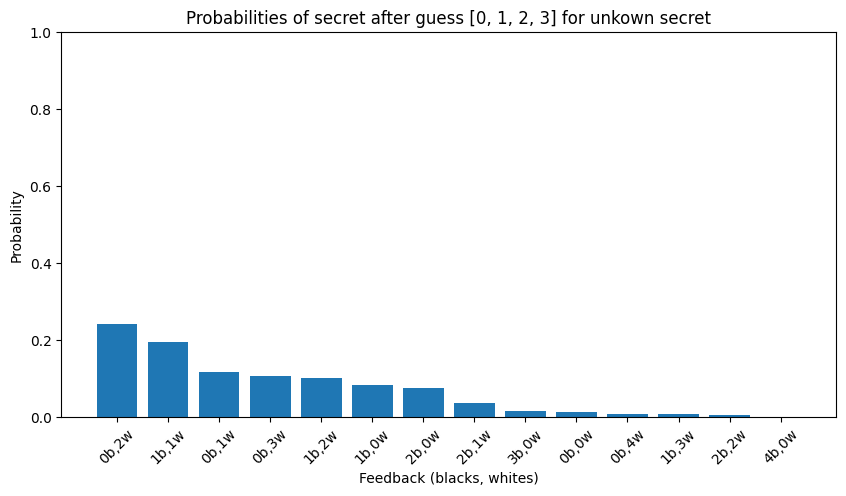

In [140]:
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt

def feedback(secret, guess):
    """Compute Mastermind feedback (blacks, whites)."""
    blacks = sum(s == g for s, g in zip(secret, guess))
    secret_counter = Counter(secret)
    guess_counter = Counter(guess)
    total_matches = sum((secret_counter & guess_counter).values())
    whites = total_matches - blacks
    return (blacks, whites)

def feedback_distribution(guess, colors=6, positions=4):
    """Compute distribution of feedback results for a given guess."""
    outcomes = Counter()
    for secret in product(range(colors), repeat=positions):
        outcomes[feedback(secret, guess)] += 1
    return outcomes

# ---- Example usage in Jupyter ----
guess = [0, 1, 2, 3]
dist = feedback_distribution(guess)
total = sum(dist.values())  # should be 6^4 = 1296

# Sort outcomes by probability (descending, highest left)
sorted_outcomes = sorted(dist.items(), key=lambda x: x[1], reverse=True)

labels = [f"{b}b,{w}w" for (b, w), _ in sorted_outcomes]
probs  = [count / total for _, count in sorted_outcomes]

plt.figure(figsize=(10,5))
plt.bar(labels, probs)
plt.xticks(rotation=45)
plt.title(f"Probabilities of secret after guess {guess} for unkown secret")
plt.xlabel("Feedback (blacks, whites)")
plt.ylabel("Probability")
plt.ylim(0, 1)  # force y-axis from 0 to 1
plt.show()

We see that after the initial guess, over 20% of combinations/candidates remain feasable if the feedback is 2 white pegs. Hence, this would leave a broad scope of possible guesses. On the other hand, 2b2w would leave only a handful of possibilities and make it rather easy to guess the secret. 

So we can say that we want to guess as far to the right of this curve as possible, because the more unlikely a guess is, the less options remain for the secret and the more information we got. 

Conclusion: information of a guess is antiproportional to the probability of a secret. The more unlikely it is, the more information we get.

But what is the exact value of this information?

### The information content

We define the information content of a guess as the negative logarithm of its probability

$I = - \log{2}{(\frac{1}{p})} bits$

In other words, if a guess has a information content of 2bits, the probability of the occurance of this event is $\frac{1}{4}$

Since we do not know the actual secret, it does not make sence to look at all posibilities and their information content individually, but rather as a joint value for all posiblilites for each combination. We define the expected information content of a possible candidate guess as: 
$$
\mathbb{E}[I] = H = \sum_{x}{p(x) * (-\log_{2}{p(x)})}
$$

This is also called the $\textit{Entropy}$ of a candidate.

Comming back to our example we calculate:

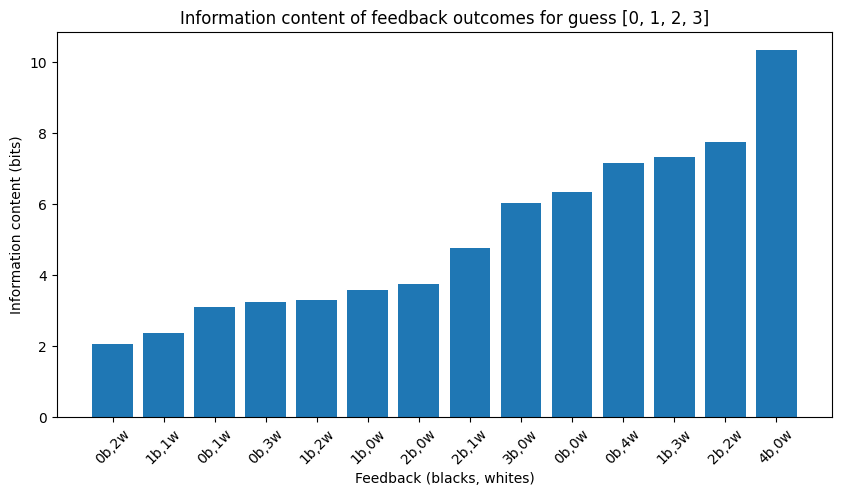

Entropy for guess [0, 1, 2, 3]: 3.0567 bits


In [141]:
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt
import math

def feedback(secret, guess):
    """Compute Mastermind feedback (blacks, whites)."""
    blacks = sum(s == g for s, g in zip(secret, guess))
    secret_counter = Counter(secret)
    guess_counter = Counter(guess)
    total_matches = sum((secret_counter & guess_counter).values())
    whites = total_matches - blacks
    return (blacks, whites)

def feedback_distribution(guess, colors=6, positions=4):
    """Compute distribution of feedback results for a given guess."""
    outcomes = Counter()
    for secret in product(range(colors), repeat=positions):
        outcomes[feedback(secret, guess)] += 1
    return outcomes

def entropy_of_guess(guess, colors=6, positions=4):
    """Shannon entropy of feedback distribution for a guess."""
    dist = feedback_distribution(guess, colors, positions)
    total = sum(dist.values())
    probs = [count / total for count in dist.values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)

# ---- Example usage ----
guess = [0, 1, 2, 3]

# Compute distribution
dist = feedback_distribution(guess)
total = sum(dist.values())

# Compute info content for each outcome
outcomes_info = []
for (b,w), count in dist.items():
    p = count / total
    I = -math.log2(p)
    outcomes_info.append(((b,w), p, I))

# Sort so highest info (rarest) is on the right
outcomes_info.sort(key=lambda x: x[2])  

labels = [f"{b}b,{w}w" for (b,w), _, _ in outcomes_info]
info   = [I for _, _, I in outcomes_info]

# Plot information content
plt.figure(figsize=(10,5))
plt.bar(labels, info)
plt.xticks(rotation=45)
plt.title(f"Information content of feedback outcomes for guess {guess}")
plt.xlabel("Feedback (blacks, whites)")
plt.ylabel("Information content (bits)")
plt.show()

# Print entropy
H = entropy_of_guess(guess)
print(f"Entropy for guess {guess}: {H:.4f} bits")

Note that the information of each possiblity is antiproportional to its probability in the graph above. The joint entropy of this candidate equals 3.06 bits, so the expected reduction of candidates in the next move is about 12% of the current candidates.

Just for building intuition, look at the information content of 4b0w (correct guess, first try) is 10.3bits. If we apply the inverse formula for information content, we get a probability of exactly $\frac{1}{1296}$, which is the exact probability of guessing the correct secret directly first try. Trivially, it is no wonder that this has then the highest information content.

---

# Entropy Solver

As we now have a metric for calculating the expected information gain of each guess, the so-called entropy, we can now solve the two problems of our initial pruding solver:

1. Problem: no good initial guess -> pick any initial guess with the highest entropy
2. Problem: no decision criteria for set of feasable candidates -> pick any candidate with highest entropy

## Best initial basis

Lets start with the first problem and find the best initial guess, for that we can compute the entropy for all $4^6$ combinations. As calculating the entropy of $4^6 = $ 1296 combinations could take some time, we can compute the isomorphisms only. $\textbf{Isomorphisms}$ are defined as a bijection.

$$
\varphi : \{0,\dots,c-1\}^p \;\to\; \{0,\dots,c-1\}^p
$$

such that for all $s,g \in \{0,\dots,c-1\}^p$:

$$
F(s,g) \;=\; F\big(\varphi(s), \varphi(g)\big).
$$

---

Isomorphisms are generated by:

1. **Color permutations**  

$$
(x_1,\dots,x_p) \;\mapsto\; (\pi(x_1),\dots,\pi(x_p)), 
\quad \pi \in S_c
$$

2. **Position permutations**  

$$
(x_1,\dots,x_p) \;\mapsto\; (x_{\sigma(1)},\dots,x_{\sigma(p)}), 
\quad \sigma \in S_p
$$

---

Hence the **isomorphism group** of Mastermind is

$$
\text{Iso}(p,c) \;\cong\; S_c \times S_p.
$$

Lets calculate all isomorphisms first before calculating entropy to optimize runtime.

In [33]:
codes # all possible candidates
isomorphisms = set() # init empty set of isomorphisms

for code in codes:
    next_label = 0
    relabeled = []
    mapping = {}

    for c in code:
        if c not in mapping:
            mapping[c] = next_label
            next_label += 1
        relabeled.append(mapping[c])

    isomorphisms.add(tuple(relabeled))

print(f"Unique isomorphisms: {len(isomorphisms)}")


Unique isomorphisms: 15


Unintuitively, there are only 15 combinations of colors, if you disregard what colors specifically. This makes entropy calculation simpler.

$\textit{Note that this only makes sence if we assume that the secret maker does not have color preferences. }$

Best starter isomorph: (0, 1, 2, 3) with entropy of 3.0566709153318903


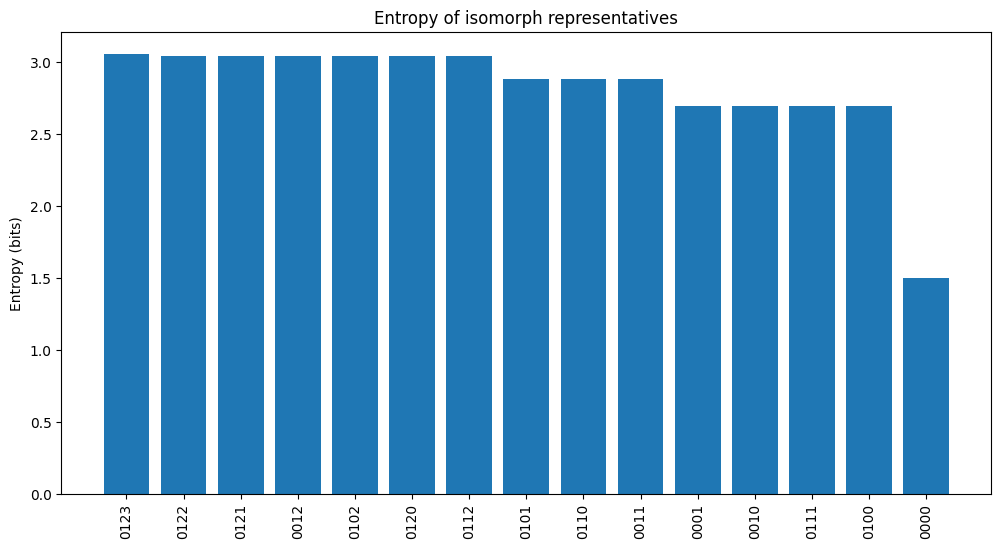

In [143]:
# Entropy calculation
def feedback(secret, guess):
    """Compute Mastermind feedback (blacks, whites)."""
    blacks = sum(s == g for s, g in zip(secret, guess))
    secret_counter = Counter(secret)
    guess_counter = Counter(guess)
    total_matches = sum((secret_counter & guess_counter).values())
    whites = total_matches - blacks
    return (blacks, whites)

def feedback_distribution(guess, colors=6, positions=4):
    """Compute distribution of feedback results for a given guess."""
    outcomes = Counter()
    for secret in product(range(colors), repeat=positions):
        outcomes[feedback(secret, guess)] += 1
    return outcomes

def entropy_of_guess(guess, colors=6, positions=4):
    """Shannon entropy of feedback distribution for a guess."""
    dist = feedback_distribution(guess, colors, positions)
    total = sum(dist.values())
    probs = [count / total for count in dist.values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)

entropies = {}
for isomorph in isomorphisms:
    entropies[isomorph] = entropy_of_guess(isomorph)

isomorph_max = max(entropies, key=entropies.get)

print(f"Best starter isomorph: {isomorph_max} with entropy of {entropies[isomorph_max]}")

sorted_items = sorted(entropies.items(), key=lambda x: x[1], reverse=True)

labels = [''.join(map(str, code)) for code, _ in sorted_items]
values = [v for _, v in sorted_items]

plt.figure(figsize=(12,6))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=90)
plt.ylabel("Entropy (bits)")
plt.title("Entropy of isomorph representatives")
plt.show()

To conclude, it makes most sense to start with four distinct colors (it does not matter which exactly if there are no color preferences). Yet, it is only sligthly better than all 3-color options which are all almost equally as good. 2-color and 1-color starters are significantly worse in terms of information gain.

---
## Entropy Ranking

To solve the second problem, we modify the naive pruning with a) our best starter b) a entropy ranking for all feasabile candidates from which we always choose the maximum.

In [74]:
from collections import Counter
import math

class pruningEntropySolver:
    def __init__(self, positions=4, colors=6, seed=None):
        self.positions = positions
        self.colors = colors
        self.last_guess = None
        self.generate_combinations()

    def next_guess(self, turn, last_result, positions, colors):
        if self.last_guess is not None and last_result is not None:
            black_count = last_result["black"]
            white_count = last_result["white"]

            revised_canditates_matrix = [] 

            for candidate in self.candidates_matrix:
                #check for each remaining combination, if it is still admissable
                if self.is_valid_candidate(candidate, black_count, white_count):
                    revised_canditates_matrix.append(candidate) # add candidate to posibilites if he is possible

            self.candidates_matrix = revised_canditates_matrix # update admissable solutions to new ones

        guess = self.pick_candidate()
        self.last_guess = guess  # remember for next feedback
        return guess
    
    def pick_candidate(self):
        entropies = {}

        for candidate in self.candidates_matrix:
            cand_tuple = tuple(candidate)
            entropies[cand_tuple] = self.entropy_of_guess(cand_tuple, self.candidates_matrix)

        best_tuple = max(entropies, key=entropies.get)
        return np.array(best_tuple)

    def entropy_of_guess(self, guess, candidates):
        """Compute Shannon entropy of feedback distribution for a guess over candidates."""
    
        def feedback(secret, guess):
            blacks = sum(s == g for s, g in zip(secret, guess))
            secret_counter = Counter(secret)
            guess_counter = Counter(guess)
            total_matches = sum((secret_counter & guess_counter).values())
            whites = total_matches - blacks
            return (blacks, whites)

        def feedback_distribution(guess, candidates):
            outcomes = Counter()
            for secret in candidates:
                outcomes[feedback(secret, guess)] += 1
            return outcomes

        dist = feedback_distribution(guess, candidates)
        total = sum(dist.values())
        probs = [count / total for count in dist.values()]
        return -sum(p * math.log2(p) for p in probs if p > 0)
    
    def is_valid_candidate(self, candidate, black_count, white_count):
        b, w = self.feedback(candidate, self.last_guess)
        return (b == black_count) and (w == white_count)
    
    def feedback(self, secret, guess):
        # Blacks
        blacks = sum(s == g for s, g in zip(secret, guess))
        # Whites
        sec_ctr = Counter(secret)
        gue_ctr = Counter(guess)
        total_matches = sum((sec_ctr & gue_ctr).values())
        whites = total_matches - blacks
        return blacks, whites
        
    def generate_combinations(self, positions=4, colors=6, dtype=np.uint8):
        """Generate all possible codes as candidate matrix."""
        base = np.arange(colors, dtype=dtype)
        grids = np.meshgrid(*([base] * positions), indexing='ij')
        self.candidates_matrix = np.stack(grids, axis=-1).reshape(-1, positions)

In [90]:
game = MasterMind(np.array([0, 0, 1, 5]))

solver = pruningEntropySolver()
simulation.play_with_visualizer(game, solver, viz, max_turns=6)

Turn  1: 🔴 🟢 🔵 🟡  | (Black: 1, White: 1) ○●
Turn  2: 🔴 🔵 🟣 🟠  | (Black: 2, White: 0) ○○
Turn  3: 🔴 🔴 🟡 🟠  | (Black: 3, White: 0) ○○○
Turn  4: 🔴 🟡 🟡 🟠  | (Black: 2, White: 0) ○○
Turn  5: 🔴 🔴 🟢 🟠  | (Black: 4, White: 0) ○○○○
--------------------------
Secret: 🔴 🔴 🟢 🟠  ->  WIN 🎉



(True, 5, array([0, 0, 1, 5], dtype=uint8))

In [73]:
import benchmark
importlib.reload(benchmark)

stats = benchmark.benchmark_solver(pruningEntropySolver, n_jobs=4)
print(stats)

Benchmarking: 100%|██████████| 1296/1296 [01:00<00:00, 21.40game/s]


{'# mean turns to guess secret': np.float64(4.41), '# maximum turns to guess secret': 6, '# losses (> 6 guesses)': 0}


**We can see that MasterMind is thus indeed a 100\% winable game as our entropy solver solved every possible game of MasterMind in around 4.45 moves on average and never more than 6 moves.**

But: can we do better?

# Further improvements and worst-case time complexity

We found a algorithm that always wins the game. But can we win faster?
This question is too vague, we need to differenciate two cases:

I. Win faster on $\textit{average}$

II. Win faster in the $\textit{worst-case}$

## Improvements on average-case complexity

We can see that entropy alone is not sufficient to find average-case optimality. If we start with basis 1234, we get an average of 4.47 moves. If we start with 1122, which has far less entropy, we get a averge-case of 4.45. But why is the expected information gain not sufficient?

TK

Consequently, two possible improvements arise.

### Entropy + Partition Balance

Pure entropy sometimes favors lopsided partitions.
To avoid this, we can add a penalty for unbalanced splits.

For a guess $g$, let $R$ be the set of all possible responses (feedbacks).
For each $r \in R$, define the partition:

$$
P(g,r) = \{ c \in \mathcal{C} : \text{feedback}(g,c) = r \}
$$

where $\mathcal{C}$ is the set of candidate codes.

For each guess \(g\), define the variance of partition sizes:

$$
V(g) = \text{Var}\big( \{ |P(g,r)| : r \in R \} \big).
$$

Then define a hybrid score:

$$
S(g) = \alpha \, H(g) - (1 - \alpha)\, \log_2 \big(1 + V(g)\big),
$$

where $\alpha \in [0,1]$ is a trade-off parameter.

We then select

$$
g^* = \arg\max_g S(g).
$$

This balances high entropy with evenly sized partitions,
reducing the chance of long tails in the average case.

In [ ]:
from collections import Counter
import math
import numpy as np

class pruningEntropyVarianceSolver:
    def __init__(self, positions=4, colors=6, seed=None, alpha=0.7):
        self.positions = positions
        self.colors = colors
        self.last_guess = None
        self.alpha = alpha  # <<< NEW: balance parameter
        self.generate_combinations()

    def next_guess(self, turn, last_result, positions, colors):
        if self.last_guess is not None and last_result is not None:
            black_count = last_result["black"]
            white_count = last_result["white"]

            revised_canditates_matrix = [] 

            for candidate in self.candidates_matrix:
                if self.is_valid_candidate(candidate, black_count, white_count):
                    revised_canditates_matrix.append(candidate)

            self.candidates_matrix = revised_canditates_matrix

        guess = self.pick_candidate()
        self.last_guess = guess
        return guess
    
    def pick_candidate(self):
        scores = {}

        for candidate in self.candidates_matrix:
            cand_tuple = tuple(candidate)
            # <<< CHANGED: use hybrid score instead of pure entropy
            scores[cand_tuple] = self.hybrid_score(cand_tuple, self.candidates_matrix)

        best_tuple = max(scores, key=scores.get)
        return np.array(best_tuple)

    def entropy_of_guess(self, guess, candidates):
        """Compute Shannon entropy of feedback distribution for a guess over candidates."""
    
        def feedback(secret, guess):
            blacks = sum(s == g for s, g in zip(secret, guess))
            secret_counter = Counter(secret)
            guess_counter = Counter(guess)
            total_matches = sum((secret_counter & guess_counter).values())
            whites = total_matches - blacks
            return (blacks, whites)

        def feedback_distribution(guess, candidates):
            outcomes = Counter()
            for secret in candidates:
                outcomes[feedback(secret, guess)] += 1
            return outcomes

        dist = feedback_distribution(guess, candidates)
        total = sum(dist.values())
        probs = [count / total for count in dist.values()]
        return -sum(p * math.log2(p) for p in probs if p > 0), dist  # <<< RETURN dist too
    
    # <<< NEW: variance of partition sizes
    def partition_variance(self, dist):
        counts = list(dist.values())
        if not counts:
            return 0.0
        mean = sum(counts) / len(counts)
        return sum((c - mean) ** 2 for c in counts) / len(counts)

    # <<< NEW: hybrid score
    def hybrid_score(self, guess, candidates):
        entropy, dist = self.entropy_of_guess(guess, candidates)
        variance = self.partition_variance(dist)
        score = self.alpha * entropy - (1 - self.alpha) * math.log2(1 + variance)
        return score
    
    def is_valid_candidate(self, candidate, black_count, white_count):
        b, w = self.feedback(candidate, self.last_guess)
        return (b == black_count) and (w == white_count)
    
    def feedback(self, secret, guess):
        blacks = sum(s == g for s, g in zip(secret, guess))
        sec_ctr = Counter(secret)
        gue_ctr = Counter(guess)
        total_matches = sum((sec_ctr & gue_ctr).values())
        whites = total_matches - blacks
        return blacks, whites
        
    def generate_combinations(self, positions=4, colors=6, dtype=np.uint8):
        base = np.arange(colors, dtype=dtype)
        grids = np.meshgrid(*([base] * positions), indexing='ij')
        self.candidates_matrix = np.stack(grids, axis=-1).reshape(-1, positions)

In [15]:
game = MasterMind(np.array([4, 0, 0, 0]))

solver = pruningEntropyVarianceSolver()
simulation.play_with_visualizer(game, solver, viz, max_turns=6)

Turn  1: 🔴 🔴 🟢 🔵  | (Black: 1, White: 1) ○●
Turn  2: 🔴 🟡 🔴 🟣  | (Black: 1, White: 2) ○●●
Turn  3: 🔴 🟣 🔵 🟡  | (Black: 0, White: 2) ●●
Turn  4: 🟡 🔴 🔴 🔴  | (Black: 3, White: 0) ○○○
Turn  5: 🟡 🔴 🔴 🟠  | (Black: 2, White: 0) ○○
Turn  6: 🟣 🔴 🔴 🔴  | (Black: 4, White: 0) ○○○○
--------------------------
Secret: 🟣 🔴 🔴 🔴  ->  WIN 🎉



(True, 6, array([4, 0, 0, 0]))

Note that this implementation is very slow and inefficient. Using GPT-5, the code was optimized for faster computational performance. The logic remains the same, while code is more complex.

In [58]:
import numpy as np

class pruningEntropyVarianceSolver:
    """
    Fast Mastermind-like solver.
    Key ideas:
      - Represent all codes once; keep candidates as an index vector into that master list.
      - Precompute pairwise blacks and total color matches for *all* code pairs (vectorized).
      - On each turn, filter candidates via a single vectorized mask using the precomputed tables.
      - Score guesses by taking submatrices and using np.bincount for outcome histograms.
    """

    def __init__(self, positions=4, colors=6, alpha=0.7):
        self.positions = int(positions)
        self.colors = int(colors)
        self.alpha = float(alpha)

        # Build full codebook (all possible codes) once.
        self._build_codebook()

        # Precompute per-code color histograms (n x colors)
        self.code_color_counts = self._counts_per_code(self.all_codes)

        # Precompute pairwise blacks and total matches (n x n), fully vectorized.
        self.blacks = self._pairwise_blacks(self.all_codes)                # exact-position matches
        self.matches = self._pairwise_total_color_matches(self.code_color_counts)  # color intersections
        self.whites = (self.matches - self.blacks).astype(np.uint8)        # correct color wrong place

        # Candidate set = all codes initially, tracked as indices into all_codes
        self.candidate_idx = np.arange(self.n_codes, dtype=np.int32)

        # Track last guess as an index into all_codes
        self.last_guess_idx = None

        # Number of (black, white) bins for histograms
        self._outcome_bins = (self.positions + 1) * (self.positions + 1)

    # ------------------------
    # Construction utilities
    # ------------------------
    def _build_codebook(self):
        base = np.arange(self.colors, dtype=np.uint8)
        grids = np.meshgrid(*([base] * self.positions), indexing='ij')
        self.all_codes = np.stack(grids, axis=-1).reshape(-1, self.positions).astype(np.uint8)
        self.n_codes = self.all_codes.shape[0]

    def _counts_per_code(self, codes):
        """
        Vectorized per-color counts for every code.
        codes: (n, P) uint8
        returns: (n, K) uint8
        """
        # one-hot across colors, then sum over positions
        # shape: (n, P, K) -> sum axis=1 -> (n, K)
        K = self.colors
        return (codes[..., None] == np.arange(K, dtype=np.uint8)).sum(axis=1).astype(np.uint8)

    def _pairwise_blacks(self, codes):
        """
        Exact-position matches for all code pairs, vectorized.
        returns: (n, n) uint8
        """
        n, P = codes.shape
        blacks = np.zeros((n, n), dtype=np.uint8)
        # Sum equality matrices per position (P is small)
        for p in range(P):
            col = codes[:, p]
            blacks += (col[:, None] == col[None, :]).astype(np.uint8)
        return blacks

    def _pairwise_total_color_matches(self, counts):
        """
        Total color intersections for all code pairs (sum_k min(count_i,k, count_j,k)).
        returns: (n, n) uint8
        """
        n, K = counts.shape
        matches = np.zeros((n, n), dtype=np.uint8)
        # Sum per color the elementwise min of outer pairs.
        for k in range(K):
            a = counts[:, k].astype(np.uint16)[:, None]  # promote to avoid tiny-temp overflows
            b = counts[:, k].astype(np.uint16)[None, :]
            matches += np.minimum(a, b).astype(np.uint8)
        return matches

    # ------------------------
    # Public API
    # ------------------------
    def generate_combinations(self, positions=4, colors=6):
        """Kept for API compatibility; codes are already prebuilt in __init__."""
        # No-op; users of the old API can still call it without harm.
        return

    # Keep a fast feedback for occasional external checks (unused internally).
    def fast_feedback(self, secret, guess):
        blacks = np.sum(secret == guess)
        sec_counts = np.bincount(secret, minlength=self.colors)
        gue_counts = np.bincount(guess, minlength=self.colors)
        total_matches = np.minimum(sec_counts, gue_counts).sum()
        whites = total_matches - blacks
        return np.array([blacks, whites], dtype=np.int8)

    def next_guess(self, turn, last_result, positions, colors):
        """
        Keeps the original signature.
        - Prunes candidates vectorized via precomputed tables.
        - Picks the best candidate using entropy - log(variance) hybrid.
        """
        # Prune based on last feedback
        if self.last_guess_idx is not None and last_result is not None:
            b = int(last_result["black"])
            w = int(last_result["white"])

            S = self.candidate_idx
            # Vectorized feedback of last guess vs all current candidates
            blacks = self.blacks[self.last_guess_idx, S]
            whites = self.whites[self.last_guess_idx, S]
            mask = (blacks == b) & (whites == w)
            self.candidate_idx = S[mask]

            if self.candidate_idx.size == 0:
                # Should never happen if feedback was consistent
                raise RuntimeError("No candidates remain after pruning; feedback may be inconsistent.")

        # Choose next guess (restrict guess pool to current candidates for speed)
        guess_idx = self._pick_candidate(self.candidate_idx, self.candidate_idx)
        self.last_guess_idx = guess_idx
        return self.all_codes[guess_idx].astype(int)  # cast to int for nice printing

    # ------------------------
    # Scoring (entropy + variance)
    # ------------------------
    def _entropy_and_variance_many(self, guess_idx_vec, secret_idx_vec):
        """
        Computes entropy and variance for multiple guesses against the same candidate set.
        Uses precomputed blacks/whites via submatrix lookups and np.bincount per row.
        """
        G = np.asarray(guess_idx_vec, dtype=np.int32)
        S = np.asarray(secret_idx_vec, dtype=np.int32)
        m = S.size
        if m == 0:
            raise RuntimeError("Empty candidate set.")

        # Gather feedback submatrices: shape (g, m)
        blacks_sub = self.blacks[np.ix_(G, S)]
        whites_sub = self.whites[np.ix_(G, S)]

        # Encode (b,w) into compact bin ids in [0, (P+1)^2)
        P = self.positions
        ids = (blacks_sub.astype(np.int16) * (P + 1) + whites_sub.astype(np.int16))

        g = G.size
        ent = np.empty(g, dtype=np.float64)
        var = np.empty(g, dtype=np.float64)

        # Compute distribution, entropy, and variance per guess using C-level bincount
        for r in range(g):
            counts = np.bincount(ids[r], minlength=self._outcome_bins)
            # drop zeros; only distinct outcomes matter for the "variance over buckets"
            nz = counts[counts > 0]
            # entropy
            p = nz / m
            ent[r] = -(p * np.log2(p)).sum()
            # variance across non-empty buckets
            mean = m / nz.size
            var[r] = ((nz - mean) ** 2).mean()

        return ent, var

    def _hybrid_scores(self, guess_idx_vec, secret_idx_vec):
        ent, var = self._entropy_and_variance_many(guess_idx_vec, secret_idx_vec)
        # alpha * entropy  - (1 - alpha) * log2(1 + variance)
        return self.alpha * ent - (1.0 - self.alpha) * np.log2(1.0 + var)

    def _pick_candidate(self, guess_pool_idx, candidate_idx):
        if guess_pool_idx.size == 1:
            return int(guess_pool_idx[0])
        
        scores = self._hybrid_scores(guess_pool_idx, candidate_idx)
        # Break ties by favoring an actual candidate with the smallest index for determinism
        best_rel = int(np.argmax(scores))
        return int(guess_pool_idx[best_rel])

In [78]:
game = MasterMind(np.array([4, 0, 0, 0]))

solver = pruningEntropyVarianceSolver()
simulation.play_with_visualizer(game, solver, viz, max_turns=6)

Turn  1: 🔴 🔴 🟢 🔵  | (Black: 1, White: 1) ○●
Turn  2: 🔴 🟡 🔴 🟣  | (Black: 1, White: 2) ○●●
Turn  3: 🔴 🟣 🔵 🟡  | (Black: 0, White: 2) ●●
Turn  4: 🟡 🔴 🔴 🔴  | (Black: 3, White: 0) ○○○
Turn  5: 🟡 🔴 🔴 🟠  | (Black: 2, White: 0) ○○
Turn  6: 🟣 🔴 🔴 🔴  | (Black: 4, White: 0) ○○○○
--------------------------
Secret: 🟣 🔴 🔴 🔴  ->  WIN 🎉



(True, 6, array([4, 0, 0, 0]))

In [89]:
import benchmark
importlib.reload(benchmark)

stats = benchmark.benchmark_solver(pruningEntropyVarianceSolver, n_jobs=6)
print(stats)























































Benchmarking: 100%|██████████| 1296/1296 [00:09<00:00, 142.23game/s]


{'# mean turns to guess secret': np.float64(4.47), '# maximum turns to guess secret': 6, '# losses (> 6 guesses)': 0}


We see slight improvements. Note that it appears that 0123 is not the best starting guess. We will explore the reasons for that later on.

Now, instead of trying to find further improvements to the algorithm, lets try to compute a theoretical mathematical limit of the average case complexity. This gives us a clear goal. If we reach it after that algorithmically, we have optimized MasterMind to the fullest.

# Theoretical average case time complexity limit